# Project 3: Understanding data representation through low-dimensional projections (subspace learning)
## Regardless of the level you are in this course, you are NOT allowed to use import tools from the scipy or sci-kit learn.  The only imports allowed on this project are pandas, numpy, and matplotlib (or plotly/seaborn if you prefer).

### Name:
### Course Level:

## Due: Monday March 24, 2025

**Introduction:**
* In this project, we explore the application of classification using: a) Principal Componenet Analysis (PCA) and b) Linear Discriminant Analysis (LDA). The project will be broken into sections in which students registered for CSC 448 will complete the first and second section, and CSC 548 students will complete all sections.

**Objectives:**
* The objective of this project is to implement different classification models to analyze real-world datasets, understand the relationship between variables, and perform classifications.  Additionally, students will gain experience understanding optimization techniques, linear algebra, and subspace learning.

## All Students

* The first problem we aim to design a pose (orientation) estimator for a set of image data.  Please download the Boat.zip file from the D2L project 3 module.

**Problem A (60pts)**

1 (5pts). The first thing you'll need to do is read the image data in and construc the image data matrix $X = [\textbf{x}_1, \textbf{x}_2, \cdots, \textbf{x}_n]$ where each column of $X$ is a "row-scanned" image
$$
    \textbf{x}_i = \text{vec}(I_i) \in \mathbb{R}^{m}
$$
where $m$ is the number of pixels in the image (i.e., turn the image into a single column vector - hint: np.reshape works here)

For this particular dataset, there are $n=128$ images sampled at a different orientation around a single degree of freedom (i.e, the object being rotated around a single axis through 360 degrees).  Each image $I \in [0,1]^{h \times v}$ where $h=v=128$ and $m=16,384$ features.  

* This will result in a image data matrix $X \in \mathbb{R}^{16,384 \times 128}$

**Note:** The .zip also contains the Testing Set (same object imaged at random angles around the same single degree of freedom) along with a .txt file providing the actual pose (orientation) of each training image.

In [1]:
# Read in the data (however you prefer), and Construct the Image data matrix X #
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# Note the images are in a folder called boat
# Load images from the Boat folder
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = Image.open(os.path.join(folder, filename))
        img = img.convert('L')  # Convert to grayscale
        img = np.array(img).flatten()  # Flatten to a 1D array
        images.append(img)
    return np.array(images).T  # Transpose to get the desired shape

X = load_images_from_folder('Boat/Train/UnProcessed')

2 (5pts). Next, we need to ensure the data is centered, so we subtract the mean image vector $\bar{\textbf{x}}$ from each image in the dataset.  Keep this for later classification! Write a function called CenterData that takes the original $X$ and returns the centered $X$ (referred to as $\bar{X}$) along with the mean vector $\bar{\textbf{x}}$ associated with $X$.

In [2]:
# Function definition here, returns the classification rate between your models predicted target and the true value #
def CenterData(d_X):
    mean_x = np.mean(d_X, axis=1, keepdims=True)
    barX = d_X - mean_x
    return barX, mean_x

3 (10pts). We will need a way to "select" the optimum subspace dimension (i.e., how many principal components to keep).  One way to do this is to use the information recovery ratio defined as:
$$
    \rho(\bar{X},\mu) = \frac{\sum_{i=1}^k \sigma_i^2}{\| \bar{X} \|^2_F} \leq \mu
$$
where $\mu \in [0,1]$ is the amount of information recovered from a $k$-dimensional subspace (note $\rho \rightarrow 1$ as $k \rightarrow n$) resulting in 100\% recovery and $\sigma_i$ is the $i^{\textbf{th}}$ singular value of $\bar{X}$.

* Write a function called InfoRecov that takes the \underline{centered} image data matrix $\bar{X}$, the mean vector $\bar{\textbf{x}}$, and user specified information recovery $\mu$ that returns the value $k$ required to acheive the user-specified information recovery.


**Note:** Generally $\mu=0.85 - 0.9$ is sufficient for good classification.

In [3]:
# Information Recovery #
def InfoRecov(barX, mean_x, mu):
    U, S, Vt = np.linalg.svd(barX, full_matrices=False)
    total_variance = np.sum(S**2)
    cumulative_variance = np.cumsum(S**2)
    k_keep = np.argmax(cumulative_variance / total_variance >= mu) + 1
    return k_keep

4 (20pts). Next write a function (called PCA) that takes the image data matrix $X$, and user specified accuracy $\mu$, to compute and return the first $k$ principal components of $X$ where $k$ is the subspace dimension required to acheive an information recovery $\mu$.  

**Note:** You will need to use the above "helper" functions to:

1. Ensure the data is centered prior to computation
2. Compute how many pricipal components to keep via the user specified information recovery $\mu$

In [4]:
# Function to compute logistic regression model parameters #
def PCA(data_X, mu):
    barX, mean_x = CenterData(data_X)
    k_keep = InfoRecov(barX, mean_x, mu)
    U, S, Vt = np.linalg.svd(barX, full_matrices=False)
    u_pca = U[:, :k_keep]
    return u_pca


5 (10pts). Next write a function called DataProjection that takes the first $k$ principal components, the centered data matrix $\bar{X}$, and computes the change of basis $Y$ embedding the data into a $k$-dimensional subspace.  To illustrate your function is working, generate a $k=3$-dimensional plot showing the low-dimensional embedding in $\mathbb{R}^3$.

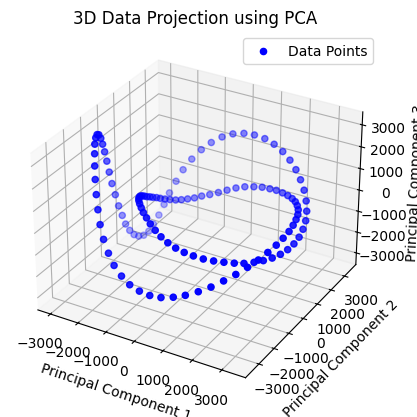

In [5]:
# Data Projection
def DataProjection(barX, u_pca):
    y_embed = np.dot(u_pca.T, barX)
    return y_embed

# Example usage
barX, mean_x = CenterData(X)
mu = 0.9
u_pca = PCA(X, mu)
y_embed = DataProjection(barX, u_pca)

# Plotting the 3D embedding
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_embed[0, :], y_embed[1, :], y_embed[2, :], c='b', marker='o', label='Data Points')

# Labeling the graph
ax.set_title('3D Data Projection using PCA')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()

plt.show()

6 (10pts). Evaluate how well your low-dimensional projection works by estimating the pose of each image in the Test Set.  You may want to write a quick helper function here but it's not required.  The process for evaluation is as follows:

1. Vectorize a test image and subtract the mean computed above $\bar{\textbf{x}}$.
2. Project the test image onto the low-dimensional subspace (performa a change of basis $\textbf{t}=U_k^T \textbf{f}$) where $U_k \in \mathbb{R}^{m \times k}$ contains the first $k$ principal components, $\textbf{f} \in \mathbb{R}^m$ is the mean-centered vectorized image, and $\textbf{t} \in \mathbb{R}^k$ is the low-dimensional projection.
3. Perform a nearest-neighbor search with all other samples in $Y$ to compute which sample in $Y$ that $\textbf{t}$ is closest to.  
4. Use the equation $est = \frac{2 \pi i}{n}$ to estimate the orientation of the test sample (where $i$ is the closest sample to $\textbf{t}$)
5. Compute the estimation error by looking at the .txt file to determine the "true" orientation and subtracting the two.
6. Do this for all 64 test samples to determine the average classification error and standard deviation across the testing set.

In [6]:
# Perform pose estimation and return the estimation results (mean and standard deviation) #
test_images = load_images_from_folder('Boat/Test/Boat32/UnProcessed')
true_orientations = np.loadtxt("Boat/Test/RandAng.txt", delimiter=",")

def pose_estimation(test_images, mean_x, u_pca, true_orientations):
    test_images_centered = test_images - mean_x
    t = np.dot(u_pca.T, test_images_centered)
    errors = []
    for i in range(t.shape[1]):
        distances = np.linalg.norm(y_embed - t[:, i].reshape(-1, 1), axis=0)
        closest_idx = np.argmin(distances)
        est_orientation = 2 * np.pi * closest_idx / y_embed.shape[1]
        true_orientation = true_orientations[i]
        errors.append(np.abs(est_orientation - true_orientation))
    return np.mean(errors), np.std(errors)

# Assuming test_images and true_orientations are loaded similarly to X
mean_error, std_error = pose_estimation(test_images, mean_x, u_pca, true_orientations)
print("Mean Error:", mean_error)
print("Standard Deviation:", std_error)

Mean Error: 1.866870221155048
Standard Deviation: 1.4354974234533677


**Problem B (45pts)**


1 (5pts). Next, let's look at a multi-class problem and compute a linear subspace (change of basis) by exploring Linear Discriminant Analysis.  

Here, we want to investigate the first three odd digits of the MNIST dataset.  Let's go ahead and get the dataset loaded (60,000 training images and 10,000 testing images)

**The data can be downloaded** [Here](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

- Note that once loaded, you will need to "parse" the training and testing set to only keep the first three odd numbers (1,3, and 5).
- These are also images (size: $28 \times 28$) so you'll need to perform the same "vectorization" of each image into a 784-dimensional vector.


Let's also plot a few digits to get the hang of working with the dataset by creating a $3 \times 3$ subplot to display 9 total digits.

**Note:** When displaying images you need to provide a colormap, these are grayscale images so our colormap will be 'gray'

* $\texttt{plt.imshow(I,cmap='gray')}$ should work.

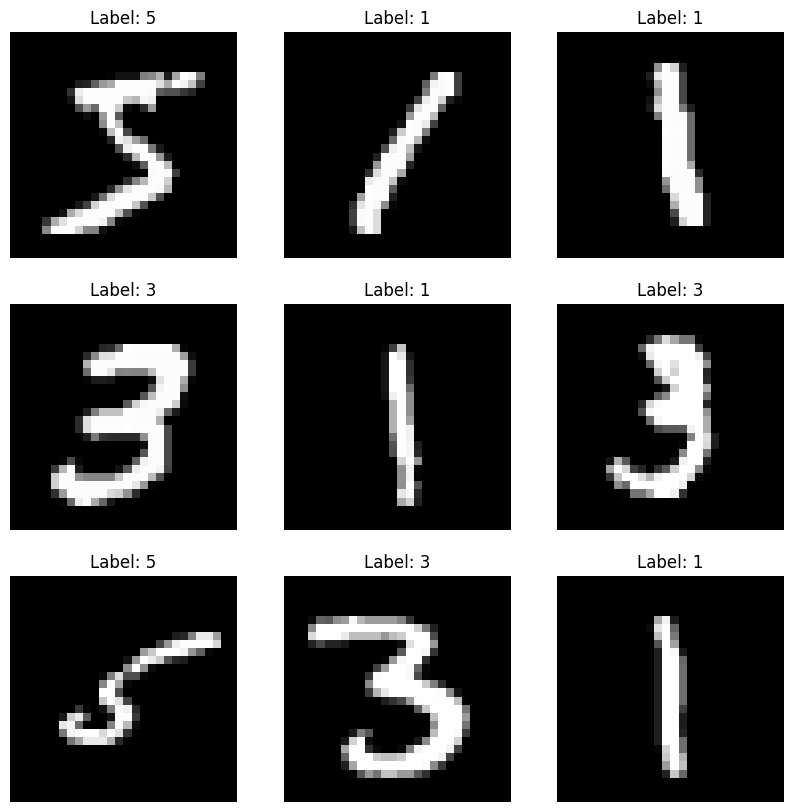

In [7]:
# load MNIST data, separte the data into only 1,3 and 5s for both training and testing, plot the first 9 digits #
# Note the data is in a folder named archive
def load_idx(filename):
    """Manually loads an IDX file using NumPy."""
    with open(filename, 'rb') as f:
        data = f.read()
    
    # Extract metadata (big-endian format)
    magic_number = int.from_bytes(data[:4], byteorder='big')
    num_items = int.from_bytes(data[4:8], byteorder='big')
    
    if magic_number == 2049:  # Label file
        return np.frombuffer(data[8:], dtype=np.uint8)
    
    elif magic_number == 2051:  # Image file
        num_rows = int.from_bytes(data[8:12], byteorder='big')
        num_cols = int.from_bytes(data[12:16], byteorder='big')
        return np.frombuffer(data[16:], dtype=np.uint8).reshape(num_items, num_rows, num_cols)

    else:
        raise ValueError("Invalid IDX file")

# File paths
train_images_path = "archive/train-images.idx3-ubyte"
train_labels_path = "archive/train-labels.idx1-ubyte"
test_images_path = "archive/t10k-images.idx3-ubyte"
test_labels_path = "archive/t10k-labels.idx1-ubyte"

# Load MNIST images and labels manually
X_train = load_idx(train_images_path)
y_train = load_idx(train_labels_path)
X_test = load_idx(test_images_path)
y_test = load_idx(test_labels_path)

mask_train = np.isin(y_train, [1, 3, 5])  # Create a boolean mask for digits 1, 3, and 5
mask_test = np.isin(y_test, [1, 3, 5])

X_train_filtered = X_train[mask_train]
y_train_filtered = y_train[mask_train]
X_test_filtered = X_test[mask_test]
y_test_filtered = y_test[mask_test]

# Plot some digits
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_filtered[i], cmap='gray')  # Display the 28x28 image
    ax.set_title(f"Label: {y_train_filtered[i]}")      # Set the title to the corresponding label
    ax.axis('off')  # Hide axes for better visualization
plt.show()

2 (30pts). Similar to the above problem A, write a function called LDA that takes the image data matrix (this can be sorted by class to make your life easier) and the number of classes and returns the $C-1$-dimensional change of basis that maximizes:
$$
    J(\textbf{w}) = \frac{\textbf{w}^T S_b \textbf{w}}{\textbf{w}^T S_w \textbf{w}}
$$
where $S_w$ is the $\textbf{within-class}$ scatter matrix and $S_b$ is the $\textbf{between-class}$ scatter matrix.

In [8]:
def LDA(x_data, y_data, c_classes):
    # Ensure input is properly formatted
    # For image data, we need to flatten the 28x28 images to 784-dimensional vectors
    if len(x_data.shape) == 3:  # If shape is (n_samples, height, width)
        n_samples = x_data.shape[0]
        x_data = x_data.reshape(n_samples, -1)  # Flatten to (n_samples, height*width)
    
    # Get dimensions
    n_samples, n_features = x_data.shape
    
    # Compute class means
    unique_classes = np.unique(y_data)
    class_means = np.zeros((c_classes, n_features))
    
    # Count samples per class
    n_samples_per_class = np.zeros(c_classes)
    
    # Calculate mean for each class
    for i, c in enumerate(unique_classes):
        idx = (y_data == c)
        class_means[i] = np.mean(x_data[idx], axis=0)
        n_samples_per_class[i] = idx.sum()
    
    # Calculate global mean
    global_mean = np.mean(x_data, axis=0)
    
    # Calculate the between-class scatter matrix Sb
    Sb = np.zeros((n_features, n_features))
    for i in range(c_classes):
        diff = class_means[i] - global_mean
        Sb += n_samples_per_class[i] * np.outer(diff, diff)
    
    # Calculate the within-class scatter matrix Sw
    Sw = np.zeros((n_features, n_features))
    for i, c in enumerate(unique_classes):
        idx = (y_data == c)
        diff = x_data[idx] - class_means[i]
        Sw += np.dot(diff.T, diff)
    
    # Handle potential singularity in Sw
    # Add a small regularization term
    Sw_reg = Sw + np.eye(n_features) * 1e-4
    
    # Compute Sw^-1 * Sb using numpy's matrix operations
    # First compute inverse of Sw
    try:
        Sw_inv = np.linalg.inv(Sw_reg)
    except np.linalg.LinAlgError:
        # If still singular, use pseudo-inverse
        Sw_inv = np.linalg.pinv(Sw_reg)
    
    # Compute the matrix M = Sw^-1 * Sb
    M = np.dot(Sw_inv, Sb)
    
    # Compute eigenvalues and eigenvectors of M
    evals, evecs = np.linalg.eig(M)
    
    # Convert complex values to real if they have negligible imaginary parts
    if np.iscomplex(evals).any():
        # Check if imaginary parts are negligible
        if np.all(np.abs(np.imag(evals)) < 1e-10):
            evals = np.real(evals)
            evecs = np.real(evecs)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    
    # Select C-1 eigenvectors corresponding to the largest eigenvalues
    w = evecs[:, :c_classes-1]
    
    return w

3 (10pts). To investigate the how well the LDA classifier works, let's use the testing set to determine the classification rates for:

* The entire testing set (assuming it has been pruned to digits 1,3 and 5)
* The classification rate for each individual digit (this will give you a feel for which representations are easier for the model to classify)

In [9]:
# Evaluate Performance #
def evaluate_lda(X_test, y_test, w, class_means_lda=None, X_train=None, y_train=None):
    import numpy as np
    
    # Ensure test data is properly formatted
    if len(X_test.shape) == 3:  # If shape is (n_samples, height, width)
        n_samples = X_test.shape[0]
        X_test = X_test.reshape(n_samples, -1)  # Flatten to (n_samples, n_features)
    
    # Project test data onto LDA space
    X_test_lda = np.dot(X_test, w)
    
    # Get unique classes
    unique_classes = np.unique(y_test)
    n_classes = len(unique_classes)
    
    # If class means in LDA space are not provided, compute them
    if class_means_lda is None:
        if X_train is not None and y_train is not None:
            # Ensure training data is properly formatted
            if len(X_train.shape) == 3:
                n_train_samples = X_train.shape[0]
                X_train = X_train.reshape(n_train_samples, -1)
            
            # Project training data
            X_train_lda = np.dot(X_train, w)
            
            # Compute class means in LDA space
            class_means_lda = np.zeros((n_classes, w.shape[1]))
            for i, c in enumerate(unique_classes):
                idx = (y_train == c)
                class_means_lda[i] = np.mean(X_train_lda[idx], axis=0)
        else:
            # Use test data to compute means (not ideal but works for demonstration)
            class_means_lda = np.zeros((n_classes, w.shape[1]))
            for i, c in enumerate(unique_classes):
                idx = (y_test == c)
                class_means_lda[i] = np.mean(X_test_lda[idx], axis=0)
    
    # Predict class for each test sample
    predictions = np.zeros_like(y_test)
    
    # For each test sample, find the closest class mean
    for i in range(X_test_lda.shape[0]):
        # Compute distances to all class means
        distances = np.zeros(n_classes)
        for j in range(n_classes):
            distances[j] = np.linalg.norm(X_test_lda[i] - class_means_lda[j])
        
        # Assign to class with minimum distance
        predicted_class_idx = np.argmin(distances)
        predictions[i] = unique_classes[predicted_class_idx]
    
    # Compute overall accuracy
    overall_accuracy = np.mean(predictions == y_test)
    
    # Compute class-specific accuracies
    class_accuracies = {}
    for c in unique_classes:
        idx = (y_test == c)
        class_accuracies[c] = np.mean(predictions[idx] == c) if np.sum(idx) > 0 else 0.0
    
    # Compute confusion matrix
    confusion = np.zeros((n_classes, n_classes), dtype=int)
    for i, true_class in enumerate(unique_classes):
        for j, pred_class in enumerate(unique_classes):
            confusion[i, j] = np.sum((y_test == true_class) & (predictions == pred_class))
    
    return overall_accuracy, class_accuracies, confusion, predictions

# Usage example for evaluating the LDA classifier
def run_lda_evaluation(X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered):
    # Step 1: Train LDA
    # Map the original labels (1,3,5) to consecutive indices (0,1,2) for LDA processing
    label_map = {1: 0, 3: 1, 5: 2}
    reverse_map = {0: 1, 1: 3, 2: 5}
    
    # Convert labels for processing
    y_train_mapped = np.array([label_map.get(y, -1) for y in y_train_filtered])
    y_test_mapped = np.array([label_map.get(y, -1) for y in y_test_filtered])
    
    # Filter out any samples with labels not in our mapping
    train_valid_idx = y_train_mapped != -1
    test_valid_idx = y_test_mapped != -1
    
    X_train_valid = X_train_filtered[train_valid_idx]
    y_train_valid = y_train_mapped[train_valid_idx]
    X_test_valid = X_test_filtered[test_valid_idx]
    y_test_valid = y_test_mapped[test_valid_idx]
    
    # Train LDA (flatten images first)
    n_train = X_train_valid.shape[0]
    X_train_flat = X_train_valid.reshape(n_train, -1)
    w = LDA(X_train_flat, y_train_valid, 3)
    
    # Step 2: Project data and compute class means in LDA space
    X_train_lda = np.dot(X_train_flat, w)
    
    # Compute class means in LDA space
    class_means_lda = np.zeros((3, w.shape[1]))
    for i in range(3):
        idx = (y_train_valid == i)
        class_means_lda[i] = np.mean(X_train_lda[idx], axis=0)
    
    # Step 3: Evaluate on test set
    n_test = X_test_valid.shape[0]
    X_test_flat = X_test_valid.reshape(n_test, -1)
    
    # Evaluate classifier
    overall_accuracy, class_accuracies, confusion, predictions = evaluate_lda(
        X_test_flat, y_test_valid, w, class_means_lda)
    
    # Convert back to original labels for reporting
    original_class_accuracies = {reverse_map[k]: v for k, v in class_accuracies.items()}
    
    # Print results
    print(f"Overall accuracy: {overall_accuracy:.4f}")
    print("\nAccuracy by digit:")
    for digit, acc in original_class_accuracies.items():
        print(f"Digit {digit}: {acc:.4f}")
    
    return overall_accuracy, original_class_accuracies, confusion

run_lda_evaluation(X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered);

Overall accuracy: 0.9684

Accuracy by digit:
Digit 1: 0.9894
Digit 3: 0.9614
Digit 5: 0.9496


**Problem C (10pts)**
* In Problem B, you investigated classifying the first three odd digits in the MNIST dataset (digits 1,3, and 5).  Considering that LDA returns at most $C-1$ subspace vectors, we can easily plot these vectors (for this problem) in $\mathbb{R}^2$ to illustrate how well the class separation is.  Let's compare this plot with our PCA subspace to see which of the two methods gives better class separation (i.e., generate a subplot with the 2-dimensional PCA embedding on the left and the 2-dimensional LDA embedding on the right)



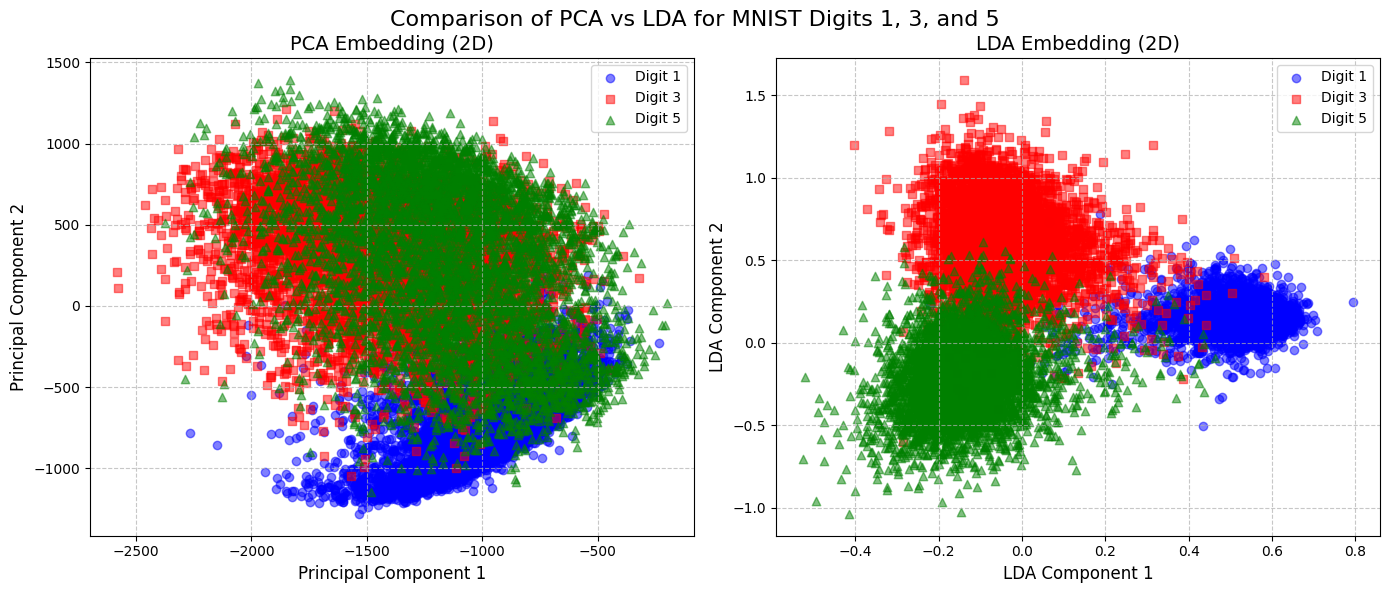

PCA Separation Metric: 1.1564
LDA Separation Metric: 4.4388
LDA/PCA Ratio: 3.8383


In [10]:
# Custom PCA transform function
def PCA_transform(data_X, mu=0.95):
    # Center the data
    barX, mean_x = CenterData(data_X)
    
    # Get SVD
    U, S, Vt = np.linalg.svd(barX, full_matrices=False)
    
    # Calculate cumulative explained variance
    var_explained = (S**2) / np.sum(S**2)
    cumulative_var = np.cumsum(var_explained)
    
    # Find number of components to keep based on mu threshold
    k_keep = np.argmax(cumulative_var >= mu) + 1
    
    # For this specific problem, we want exactly 2 components
    k_keep = 2
    
    # Get PCA projection matrix
    u_pca = U[:, :k_keep]
    
    # Project data
    X_pca = np.dot(barX, Vt[:k_keep].T)
    
    return X_pca

# Prepare the data (flatten the images)
X_train_flattened = X_train_filtered.reshape(X_train_filtered.shape[0], -1)
X_test_flattened = X_test_filtered.reshape(X_test_filtered.shape[0], -1)

# Number of classes
n_classes = 3  # digits 1, 3, and 5

# Apply custom PCA to reduce to 2 dimensions
X_train_pca = PCA_transform(X_train_flattened, mu=0.95)

# Apply LDA using the provided function
# Apply LDA to get projection matrix
lda_projection = LDA(X_train_flattened, y_train_filtered, n_classes)

# Project the data onto the LDA subspace
X_train_lda = np.dot(X_train_flattened, lda_projection)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Define colors and markers for each class
colors = ['blue', 'red', 'green']
markers = ['o', 's', '^']
class_labels = [1, 3, 5]

# Plot PCA results
for i, (c, m, label) in enumerate(zip(colors, markers, class_labels)):
    mask = y_train_filtered == label
    axes[0].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], c=c, marker=m, alpha=0.5, label=f'Digit {label}')

axes[0].set_title('PCA Embedding (2D)', fontsize=14)
axes[0].set_xlabel('Principal Component 1', fontsize=12)
axes[0].set_ylabel('Principal Component 2', fontsize=12)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot LDA results
for i, (c, m, label) in enumerate(zip(colors, markers, class_labels)):
    mask = y_train_filtered == label
    # Handle potential complex numbers by taking real part
    if np.iscomplexobj(X_train_lda):
        X_train_lda = X_train_lda.real
    axes[1].scatter(X_train_lda[mask, 0], X_train_lda[mask, 1], c=c, marker=m, alpha=0.5, label=f'Digit {label}')

axes[1].set_title('LDA Embedding (2D)', fontsize=14)
axes[1].set_xlabel('LDA Component 1', fontsize=12)
axes[1].set_ylabel('LDA Component 2', fontsize=12)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.suptitle('Comparison of PCA vs LDA for MNIST Digits 1, 3, and 5', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Evaluate class separation quantitatively
def calculate_separation_metric(X, y, classes):
    """
    Calculate a simple separation metric based on the ratio of 
    between-class to within-class scatter.
    """
    # Calculate class means
    class_means = {}
    for c in classes:
        mask = y == c
        class_means[c] = np.mean(X[mask], axis=0)
    
    # Calculate global mean
    global_mean = np.mean(X, axis=0)
    
    # Calculate between-class scatter
    between_scatter = 0
    for c in classes:
        mask = y == c
        n_samples = np.sum(mask)
        diff = class_means[c] - global_mean
        between_scatter += n_samples * np.sum(diff**2)
    
    # Calculate within-class scatter
    within_scatter = 0
    for c in classes:
        mask = y == c
        for sample in X[mask]:
            diff = sample - class_means[c]
            within_scatter += np.sum(diff**2)
    
    # Return ratio (higher is better)
    if within_scatter == 0:
        return float('inf')  # Avoid division by zero
    return between_scatter / within_scatter

# Calculate separation metrics
pca_separation = calculate_separation_metric(X_train_pca, y_train_filtered, class_labels)
lda_separation = calculate_separation_metric(X_train_lda, y_train_filtered, class_labels)

print(f"PCA Separation Metric: {pca_separation:.4f}")
print(f"LDA Separation Metric: {lda_separation:.4f}")
print(f"LDA/PCA Ratio: {lda_separation/pca_separation:.4f}")

## CSC 548 Only!

**Problem D (10pts)**
* In class we discussed the when dealing with image data, the image vectors can be extremely larde and there computing the covariance matrix becomes intractable.  We also "claimed" that we could instead use the Singular Value Decomposition to provide the appropriate PCA subspace.  Show $\textbf{mathimatically}$ that this is indeed true.  That is, given the covariance matrix:
$$
    C = \frac{1}{n-1} X X^T
$$
show that for the eigenvalue decomposition
$$
    C \textbf{v} = \lambda \textbf{v}
$$
the eigenvectors $\textbf{v}$ are exactly the left-sigular vectors of $SDV(X)$ and that the eigenvalues $\lambda$ are exactly the square-root of the singular values $\sigma$ of $SVD(X)$.



<ins>*Solution:*</ins>